# Notebook for testing Adaptive Approximate Metropolis-Hastings

In [27]:
%run _init_notebook.ipynb
from approxmh.vae import VAE, AdaptiveVAETrainer
from approxmh.distributions import create_serpentine, create_random_gaussian_mixture, IndependentMultivariateNormal, Funnel
from approxmh.samplers import AdaptiveVAESampler
from approxmh.utilities import visualize_distribution
from approxmh.likelihood_estimators import SISLikelihoodEstimator, IWLikelihoodEstimator
from approxmh.y_utils import *
from approxmh.distribution_metrics import CoordinateDistributionMetric, TotalVariation1d
from approxmh.rnvp import RNVP
from approxmh.flow_trainer import AdaptiveFlowTrainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device: cpu


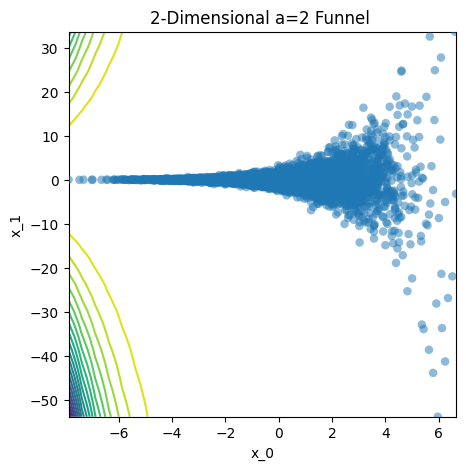

In [25]:
# target = create_serpentine(n_sections=3, section_height=1, section_width=1, device=device)
# target = create_random_gaussian_mixture(dim=2, n_components=10, variance_lim=(0.0001, 0.001), seed=39)
# target = IndependentMultivariateNormal(mean=torch.tensor([0., -5.]), std=torch.tensor(0.1))
target = Funnel(dim=2, a=2)
initial_sample = torch.distributions.Normal(loc=torch.tensor([1.0, 0.0]), scale=0.25).sample((200,))
# initial_sample = target.sample((500,))
visualize_distribution(target, sample_size=6_000, levels=20, plot_samples=True)
# plt.gca().scatter(*pl(initial_sample), zorder=4, alpha=0.9)

In [57]:
vae = VAE(
    data_dim=target.dim,
    hidden_dims=(4, 4, 4, 4, 4, 4),
    latent_dim=target.dim,
    device=device
)
vae_ml_estimator = IWLikelihoodEstimator(
    model=vae,
    L=128,
#    time_step=0.8,
#    precondition=True
)
vae_trainer = AdaptiveVAETrainer(
    target=target,
    model=vae,
    model_log_likelihood=vae_ml_estimator,
    initial_sample=initial_sample,
    device=device,
    optimizer='adam',
    lr=1e-3,
    backward_kl_factor=0.0
)

flow = RNVP(num_blocks=6, dim=target.dim, device=device)
flow_trainer = AdaptiveFlowTrainer(
    flow, target, device=device,
    forward_kl_factor=1,
    backward_kl_factor=1,
    optimizer='adam',
    lr=1e-3
)

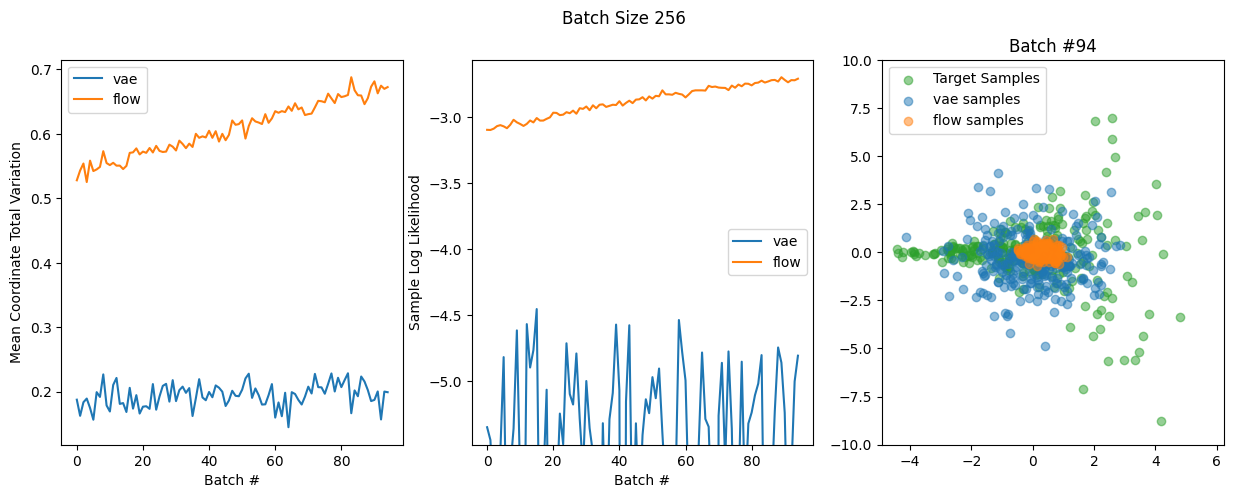

KeyboardInterrupt: 

In [60]:
# %%time

def visualize_training():
    n_batches = 200
    batch_size = 256
    metric = CoordinateDistributionMetric(TotalVariation1d(), projection_coordinates=(0,1))
    models = [
        ('vae', vae, vae_trainer),
        ('flow', flow, flow_trainer)
    ]
    
    target_samples = target.sample((batch_size,))
    test_logs = defaultdict(list)
    for _, model, __ in models:
        model.train()
    
    for batch_idx in range(n_batches):
        clear_output(wait=True)
        fig, axs = plt.subplots(ncols=3, figsize=(15,5))
        fig.suptitle(f'Batch Size {batch_size}')

        axs[2].scatter(*pl(target_samples), label='Target Samples', alpha=0.5, color='tab:green')
        xlim = axs[2].get_xlim()
        ylim = axs[2].get_ylim()
        
        for model_name, model, trainer in models:
            model_samples = trainer.sample_and_train(batch_size=batch_size)
            test_logs[model_name + '_likelihood'].append(target.log_prob(model_samples).mean().item())
            test_logs[model_name + '_metric'].append(metric(target_samples, model_samples))
            axs[2].scatter(*pl(model_samples), label=model_name + ' samples', alpha=0.5)
        
        ax = axs[2]
        ax.set_title(f'Batch #{batch_idx}')
        ax.set_xlim(xlim)
        ax.set_ylim(-10, 10)

        ax = axs[0]
        ax.set_xlabel('Batch #')
        ax.set_ylabel(metric.name())
        for model_name, _, __ in models:
            ax.plot(np.arange(batch_idx + 1), test_logs[model_name + '_metric'], label=model_name)

        ax = axs[1]
        ax.set_xlabel('Batch #')
        ax.set_ylabel('Sample Log Likelihood')
        for model_name, _, __ in models:
            ax.plot(np.arange(batch_idx + 1), test_logs[model_name + '_likelihood'], label=model_name)
        ymin = min([test_logs[model_name + '_likelihood'][0] for model_name, _, __ in models])
        ymax = max([np.max(test_logs[model_name + '_likelihood']) for model_name, _, __ in models])
        padding = 0.05
        yrange = ymax - ymin
        ax.set_ylim(ymin - padding*yrange, ymax + padding*yrange)

        for ax in axs:
            ax.legend()
        
        plt.show()
        sleep(1)
    
    vae.eval()

visualize_training()

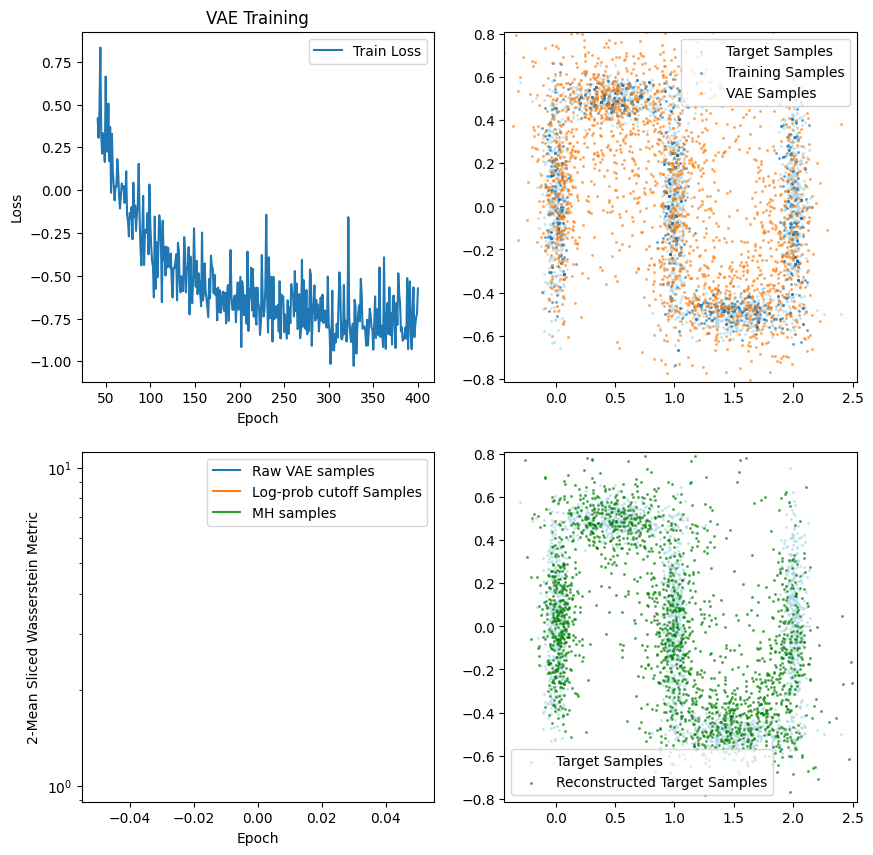

Epoch 400
	Train loss: -0.5741
	Validation loss: -0.9032
	Learning rate: 0.002
0 samples cut


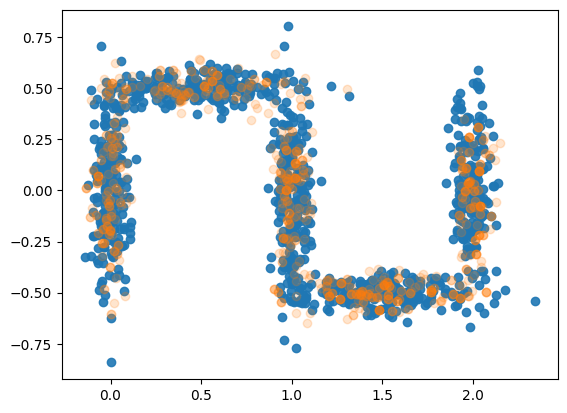

In [128]:
def retrain_and_sample():
    adaptive_sampler.retrain(
        optimizer='adam',
        lr=2e-3,
        n_epochs=400,
        kl_annealing_epochs=100,
        no_kl_penalty_epochs=20,
        plot_interval=20,
        clear_sample_history=True,
        warm_start=False
    )

    n_samples = 1000
    corrected_samples = adaptive_sampler.sample(n_samples)
    
    fig, ax = plt.subplots()
    ax.scatter(*pl(target.sample((n_samples,))), alpha=0.9)
    ax.scatter(*pl(corrected_samples), alpha=0.2)

retrain_and_sample()

In [25]:
test_tensor = torch.tensor([20.5203, -0.4022])
print(target(test_tensor), vae_ml_estimator(test_tensor))

tensor(-2895.1528) tensor([-6742.7866])


In [52]:
print(adaptive_sampler.probability_cutoff.min_log_prob)
tnsr = torch.tensor([0.0, 0.5])
target.log_prob(tnsr)

tensor(-7.6440)


tensor(-0.3721)